<a href="https://colab.research.google.com/github/flavio-mota/sin260-ML/blob/main/Agrupamento_SOM_e_Agrupamento_Espectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIN260 - Sistemas Inteligentes
## Agrupamento - SOM e Agrupamento Espectral

Isabela Neves Drummond
<br>Flávio Belizário S. Mota
<hr>

O objetivo deste notebook jupyter é apresentar uma aplicação da rede SOM e o agrupamento espectral.

## Executando o SOM em um exemplo prático

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets

As funções abaixo implementam uma rede SOM com métodos explicítos para cálculo da melhor unidade que se aproxima dos dados, atualização dos pesos e treino do mapa:

In [ ]:
# Best Matching Unit
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)
    
def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM    

def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

Um dos exemplos comumente citados para treinar um SOM é o de cores aleatórias. Podemos treinar um mapa SOM e visualizar facilmente como várias cores semelhantes são organizadas em células vizinhas.

> Células distantes umas das outras têm cores diferentes.

Vamos executar a função `train_SOM()` em uma matriz de dados de treinamento preenchida com cores RGB aleatórias.

O código abaixo inicializa uma matriz de dados de treinamento e um mapa SOM com cores RGB aleatórias. Ele também exibe os dados de treinamento e o SOM inicializado aleatoriamente. Observe que a matriz de treinamento é uma matriz de 3000x3, no entanto, nós a reformulamos para uma matriz de 50x60x3 para visualização:

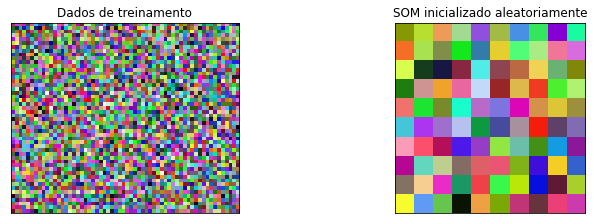

In [ ]:
# Dimensões
m = 10
n = 10
# Nº de amostras
n_x = 3000
rand = np.random.RandomState(0)

train_data = rand.randint(0, 255, (n_x, 3))

SOM = rand.randint(0, 255, (m, n, 3)).astype(float)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(train_data.reshape(50, 60, 3))
ax[0].title.set_text('Dados de treinamento')
ax[1].imshow(SOM.astype(int))
ax[1].title.set_text('SOM inicializado aleatoriamente')

Vamos agora treinar o SOM e verificá-lo a cada 5 épocas para ter uma visão geral de seu progresso:

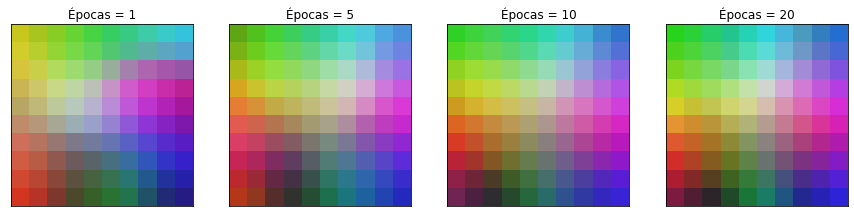

In [ ]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
for epochs, i in zip([1, 4, 5, 10], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, train_data, epochs=epochs)
    ax[i].imshow(SOM.astype(int))
    ax[i].title.set_text('Épocas = ' + str(total_epochs))

O exemplo acima é muito interessante, pois mostra como a grade organiza automaticamente as cores RGB para que vários tons da mesma cor fiquem próximos na grade SOM. O arranjo ocorre já na primeira época, mas não é o ideal. Podemos ver que o SOM converge em cerca de 10 épocas e há menos mudanças nas épocas subsequentes.

### Efeito da Taxa de Aprendizagem e Raio de vizinhança

Para ver como a taxa de aprendizado varia para diferentes taxas e raios de vizinhança, podemos executar o SOM por 10 épocas iniciando com uma mesma grade inicial. O código abaixo treina o SOM para três valores diferentes da taxa de aprendizado e três raios diferentes.

O SOM é renderizado após 5 épocas para cada simulação:

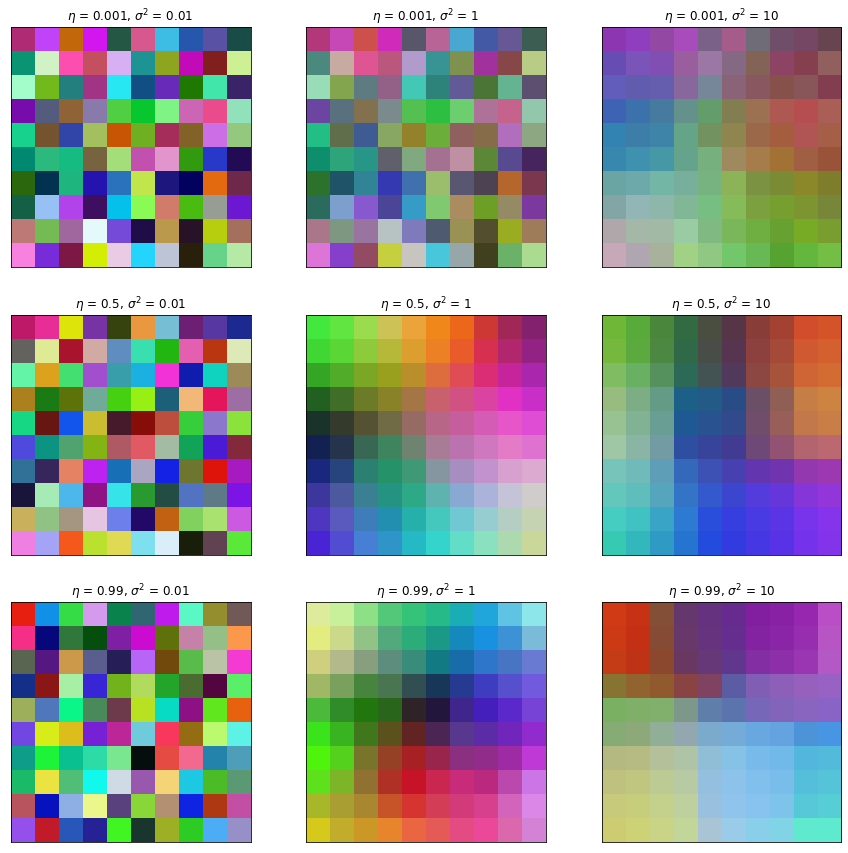

In [ ]:
fig, ax = plt.subplots(
    nrows=3, ncols=3, figsize=(15, 15), 
    subplot_kw=dict(xticks=[], yticks=[]))

# Initialize the SOM randomly to the same state

for learn_rate, i in zip([0.001, 0.5, 0.99], [0, 1, 2]):
    for radius_sq, j in zip([0.01, 1, 10], [0, 1, 2]):
        rand = np.random.RandomState(0)
        SOM = rand.randint(0, 255, (m, n, 3)).astype(float)        
        SOM = train_SOM(SOM, train_data, epochs = 5,
                        learn_rate = learn_rate, 
                        radius_sq = radius_sq)
        ax[i][j].imshow(SOM.astype(int))
        ax[i][j].title.set_text('$\eta$ = ' + str(learn_rate) + 
                                ', $\sigma^2$ = ' + str(radius_sq))

O exemplo acima mostra que para valores de raio próximos a zero (primeira coluna), o SOM altera apenas as células individuais, mas não as células vizinhas. Portanto, um mapa adequado não é criado, independentemente da taxa de aprendizado. Um caso semelhante também é encontrado para taxas de aprendizado menores (primeira linha, segunda coluna). Como em qualquer outro algoritmo de aprendizado de máquina, é necessário um bom equilíbrio de parâmetros para um treinamento ideal.

## Limitação do K-Médias quando os grupos têm formas irregulares 

Os códigos abaixo geram distribuições de dados com agrupamentos nos quais o K-médias falha em encontrar os grupos corretamente. Para contornar o problema, o agrupamento espectral pode ser empregado.

O agrupamento espectral usa algo chamado truque do kernel para introduzir dimensões adicionais aos dados. Um exemplo comum disso é tentar agrupar um círculo dentro de outro (círculos concêntricos). O K-médias não fará isso e acabará desenhando uma linha que cruza os círculos.
O agrupamento espectral introduzirá uma dimensão adicional que efetivamente move um dos círculos para longe do outro na dimensão adicional. Isso tem a desvantagem de ser computacionalmente mais caro do que o agrupamento K-médias.

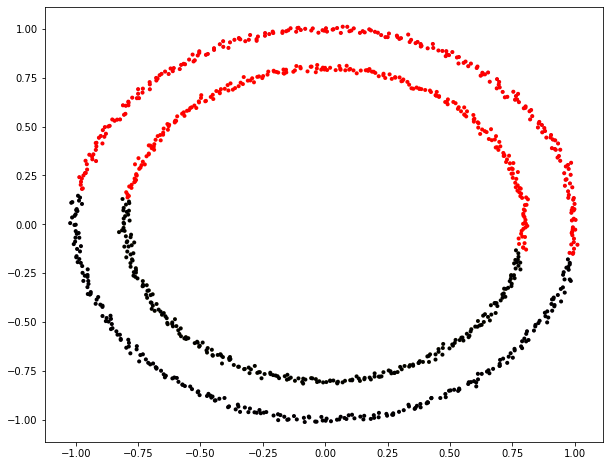

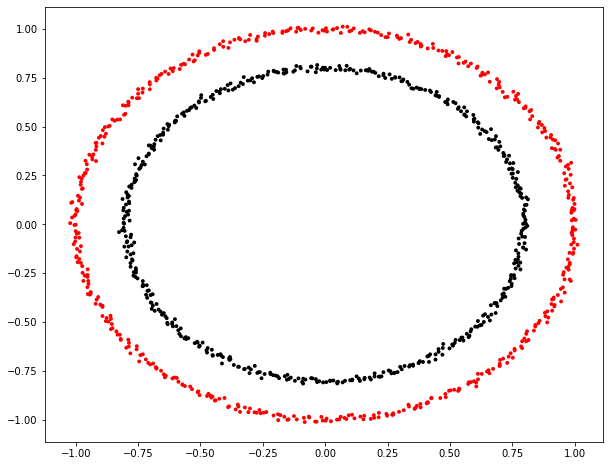

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


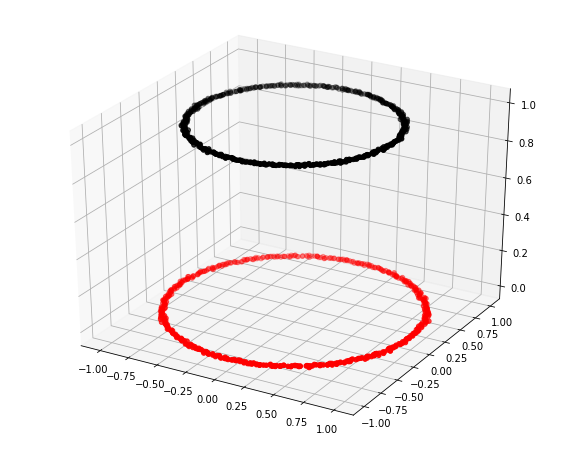

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import mpl_toolkits.mplot3d as plt3d
import sklearn.cluster as skl_cluster
import sklearn.datasets as skl_data
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def plot_3d_separation(circles,labels,dimension):

    #create two empty arrays for the points inside a list
    circles2 = [np.zeros([int(dimension/2),3]),np.zeros([int(dimension/2),3])]

    circle_indicies = [0,0]
    for i in range(0,dimension):
        x = circles[i][0]
        y = circles[i][1]
        label = labels[i]
        j = circle_indicies[label]
        circles2[label][j][0] = x
        circles2[label][j][1] = y
        circles2[label][j][2] = label
        circle_indicies[label] = circle_indicies[label] + 1

    fig = plt.figure(figsize = (10,8))
    ax = fig.gca(projection='3d')
    ax.scatter(circles2[0][:, 0],circles2[0][:, 1],circles2[0][:, 2],c=matplotlib.cm.flag(0))
    ax.scatter(circles2[1][:, 0],circles2[1][:, 1],circles2[1][:, 2],c=matplotlib.cm.flag(255))

    plt.show()


def cluster_circles():

    circles, circles_clusters = skl_data.make_circles(n_samples=1000, noise=.01, random_state=0)

    plt.figure(figsize = (10,8))
    plt.scatter(circles[:, 0], circles[:, 1], s=5, c=circles_clusters)

    Kmean = skl_cluster.KMeans(n_clusters=2)

    # run the kmeans algorithm on the data
    Kmean.fit(circles)

    # use the kmeans predictor to work out which class each item is in
    clusters = Kmean.predict(circles)

    # plot the data, colouring it by cluster
    plt.scatter(circles[:, 0], circles[:, 1], s=15, linewidth=0.1, c=clusters,cmap='flag')
    plt.show()

    model = skl_cluster.SpectralClustering(n_clusters=2,
                                           affinity='nearest_neighbors',
                                           assign_labels='kmeans')

    labels = model.fit_predict(circles)
    #print(labels)
    plt.figure(figsize = (10,8))
    plt.scatter(circles[:, 0], circles[:, 1], s=15, linewidth=0, c=labels, cmap='flag')
    plt.show()
    # uncomment to show separation in 3D
    plot_3d_separation(circles,labels,1000)

cluster_circles()

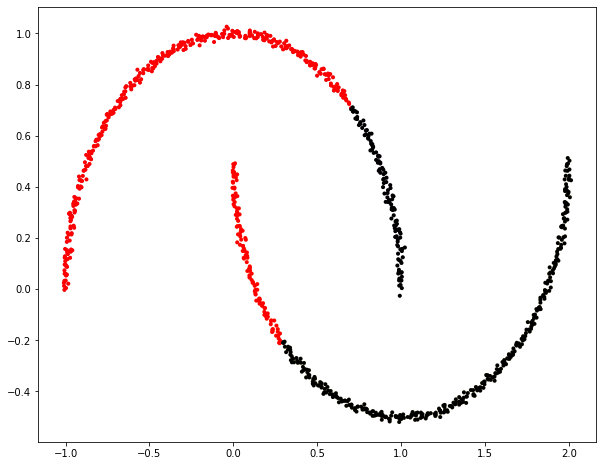

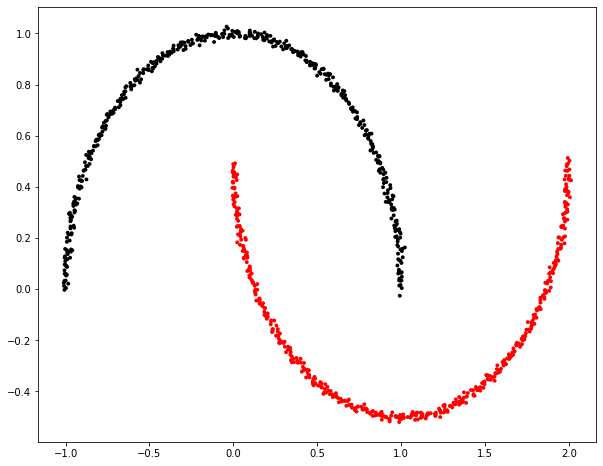

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


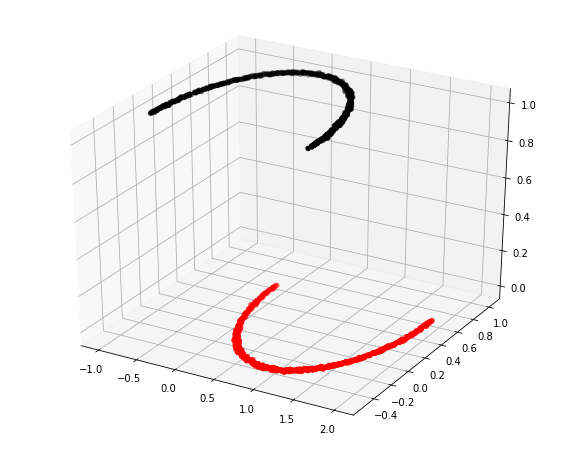

In [ ]:
def cluster_moons():

    moons, moons_clusters = skl_data.make_moons(n_samples=1000, noise=.01, random_state=0)
    plt.figure(figsize = (10,8))
    plt.scatter(moons[:, 0], moons[:, 1], s=5, c=moons_clusters)

    Kmean = skl_cluster.KMeans(n_clusters=2)

    # run the kmeans algorithm on the data
    Kmean.fit(moons)

    # use the kmeans predictor to work out which class each item is in
    clusters = Kmean.predict(moons)

    # plot the data, colouring it by cluster
    plt.scatter(moons[:, 0], moons[:, 1], s=15, linewidth=0.1, c=clusters,cmap='flag')
    plt.show()

    model = skl_cluster.SpectralClustering(n_clusters=2,
                                           affinity='nearest_neighbors',
                                           assign_labels='kmeans')

    labels = model.fit_predict(moons)
    #print(labels)
    plt.figure(figsize = (10,8))
    plt.scatter(moons[:, 0], moons[:, 1], s=15, linewidth=0, c=labels, cmap='flag')
    plt.show()
    # uncomment to show separation in 3D
    plot_3d_separation(moons,labels,1000)

cluster_moons()

## Fontes:

1. [Self-Organizing Maps: Theory and Implementation in Python with NumPy](https://stackabuse.com/self-organizing-maps-theory-and-implementation-in-python-with-numpy/)

2. [Clustering with Scikit Learn](https://scw-aberystwyth.github.io/machine-learning-novice/04-clustering/index.html)